In [3]:
import numpy as np
from pathlib import Path
import pickle
from tqdm import tqdm
from numba import njit
from mpmath import coulombf

import rose
from rose.training import multiple_formatter
from rose.training import latin_hypercube_sample

In [4]:
from matplotlib.ticker import StrMethodFormatter
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot as plt
from matplotlib import rcParams

colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]


plt.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rcParams[
    "text.latex.preamble"
] = r"\usepackage{amssymb} \usepackage{amsmath} \usepackage{braket}"
plt.rc("text", usetex=True)

rcParams["legend.fontsize"] = 12
rcParams["font.size"] = 12
rcParams["font.weight"] = "normal"
rcParams["xtick.labelsize"] = 12.0
rcParams["ytick.labelsize"] = 12.0
rcParams["lines.linewidth"] = 2.0
rcParams["xtick.major.pad"] = "10"
rcParams["ytick.major.pad"] = "10"
rcParams["image.cmap"] = "BuPu"

## Read training and test solutions

In [5]:
params = np.load("./global_kd_params.npy")
lower_bound = np.min(params, axis=(0, 1))
upper_bound = np.max(params, axis=(0, 1))
bounds = np.vstack([lower_bound, upper_bound]).T
bounds[0,0] = 1e-1
frozen_params = bounds[:,1] == bounds[:,0]
unfrozen_mask = np.logical_not(frozen_params)
param_labels  =np.asarray(
    [
        r"$E$",
        r"$\mu$",
        r"$v_v$",
        r"$r_v$",
        r"$a_v$",
        r"$v_w$",
        r"$r_{w}$",
        r"$a_{w}$",
        r"$v_d$",
        r"$r_{d}$",
        r"$a_d$",
        r"$v_{so}$", 
        r"$r_{so}$",
        r"$a_{so}$",
        r"$w_{so}$",
        r"$r_{wso}$",
        r"$a_{wso}$",
    ]

)

In [6]:
bounds

array([[ 1.00000000e-01,  5.00000000e+01],
       [ 9.27253291e+02,  9.83439040e+02],
       [ 3.24862646e+01,  5.09474947e+01],
       [ 5.11769037e+00,  6.88789256e+00],
       [ 6.51777500e-01,  6.66498800e-01],
       [ 8.71746944e-02,  4.80302097e+00],
       [ 5.11769037e+00,  6.88789256e+00],
       [ 6.51777500e-01,  6.66498800e-01],
       [ 2.67172625e+00,  6.73960839e+00],
       [ 5.40178569e+00,  7.01274719e+00],
       [ 5.15620000e-01,  5.32014400e-01],
       [ 4.85189971e+00,  6.27749683e+00],
       [ 4.37414528e+00,  5.98346936e+00],
       [ 5.90000000e-01,  5.90000000e-01],
       [-3.74068604e-01, -5.36334245e-03],
       [ 4.37414528e+00,  5.98346936e+00],
       [ 5.90000000e-01,  5.90000000e-01]])

In [7]:
# use log(E) space
scaleE = 1.0
def forward_pspace_transform(sample):
    return np.hstack([ np.log(sample[0]/scaleE), sample[1:]])

def backward_pspace_transform(sample):
    return np.hstack([np.exp(sample[0])*scaleE, sample[1:]])

In [8]:
# sample parameters in log(E) space
log_energy_bounds = bounds.copy()
log_energy_bounds = np.vstack(
    [
        forward_pspace_transform(log_energy_bounds[:,0]).T,
        forward_pspace_transform(log_energy_bounds[:,1]).T,
    ]).T

In [9]:
train = np.load("train.npy")
test = np.load("test.npy")

In [10]:
pot_terms_up = np.load("pot_terms_up.npy")
pot_terms_down = np.load("pot_terms_down.npy")

In [11]:
hf_solns_down = np.load("hf_solns_down.npy")
hf_solns_up = np.load("hf_solns_up.npy")

In [12]:
free_solns = np.load("free_solns.npy")

In [13]:
l_max=10
angles = np.linspace(0, np.pi, 200)
s_mesh = np.linspace(1e-2, 8 * np.pi, 1000)
domain = np.array([s_mesh[0], s_mesh[-1]])
s_0 = 7 * np.pi

In [14]:
interactions = rose.koning_delaroche.EnergizedKoningDelaroche(
    training_info=bounds,
    n_basis=15,
    l_max=l_max,
    n_train=10,
)
sae = rose.ScatteringAmplitudeEmulator.HIFI_solver(
    base_solver=rose.SchroedingerEquation.make_base_solver(
        s_0=s_0,
        domain=domain,
    ),
    interaction_space=interactions,
    angles=angles,
    s_mesh=s_mesh,
)

/home/kyle/umich/rose/src/rose/scattering_amplitude_emulator.py:354: RuntimeWarning: invalid value encountered in divide
  self.rutherford = 0.0 / (np.sin(self.angles / 2) ** 4)


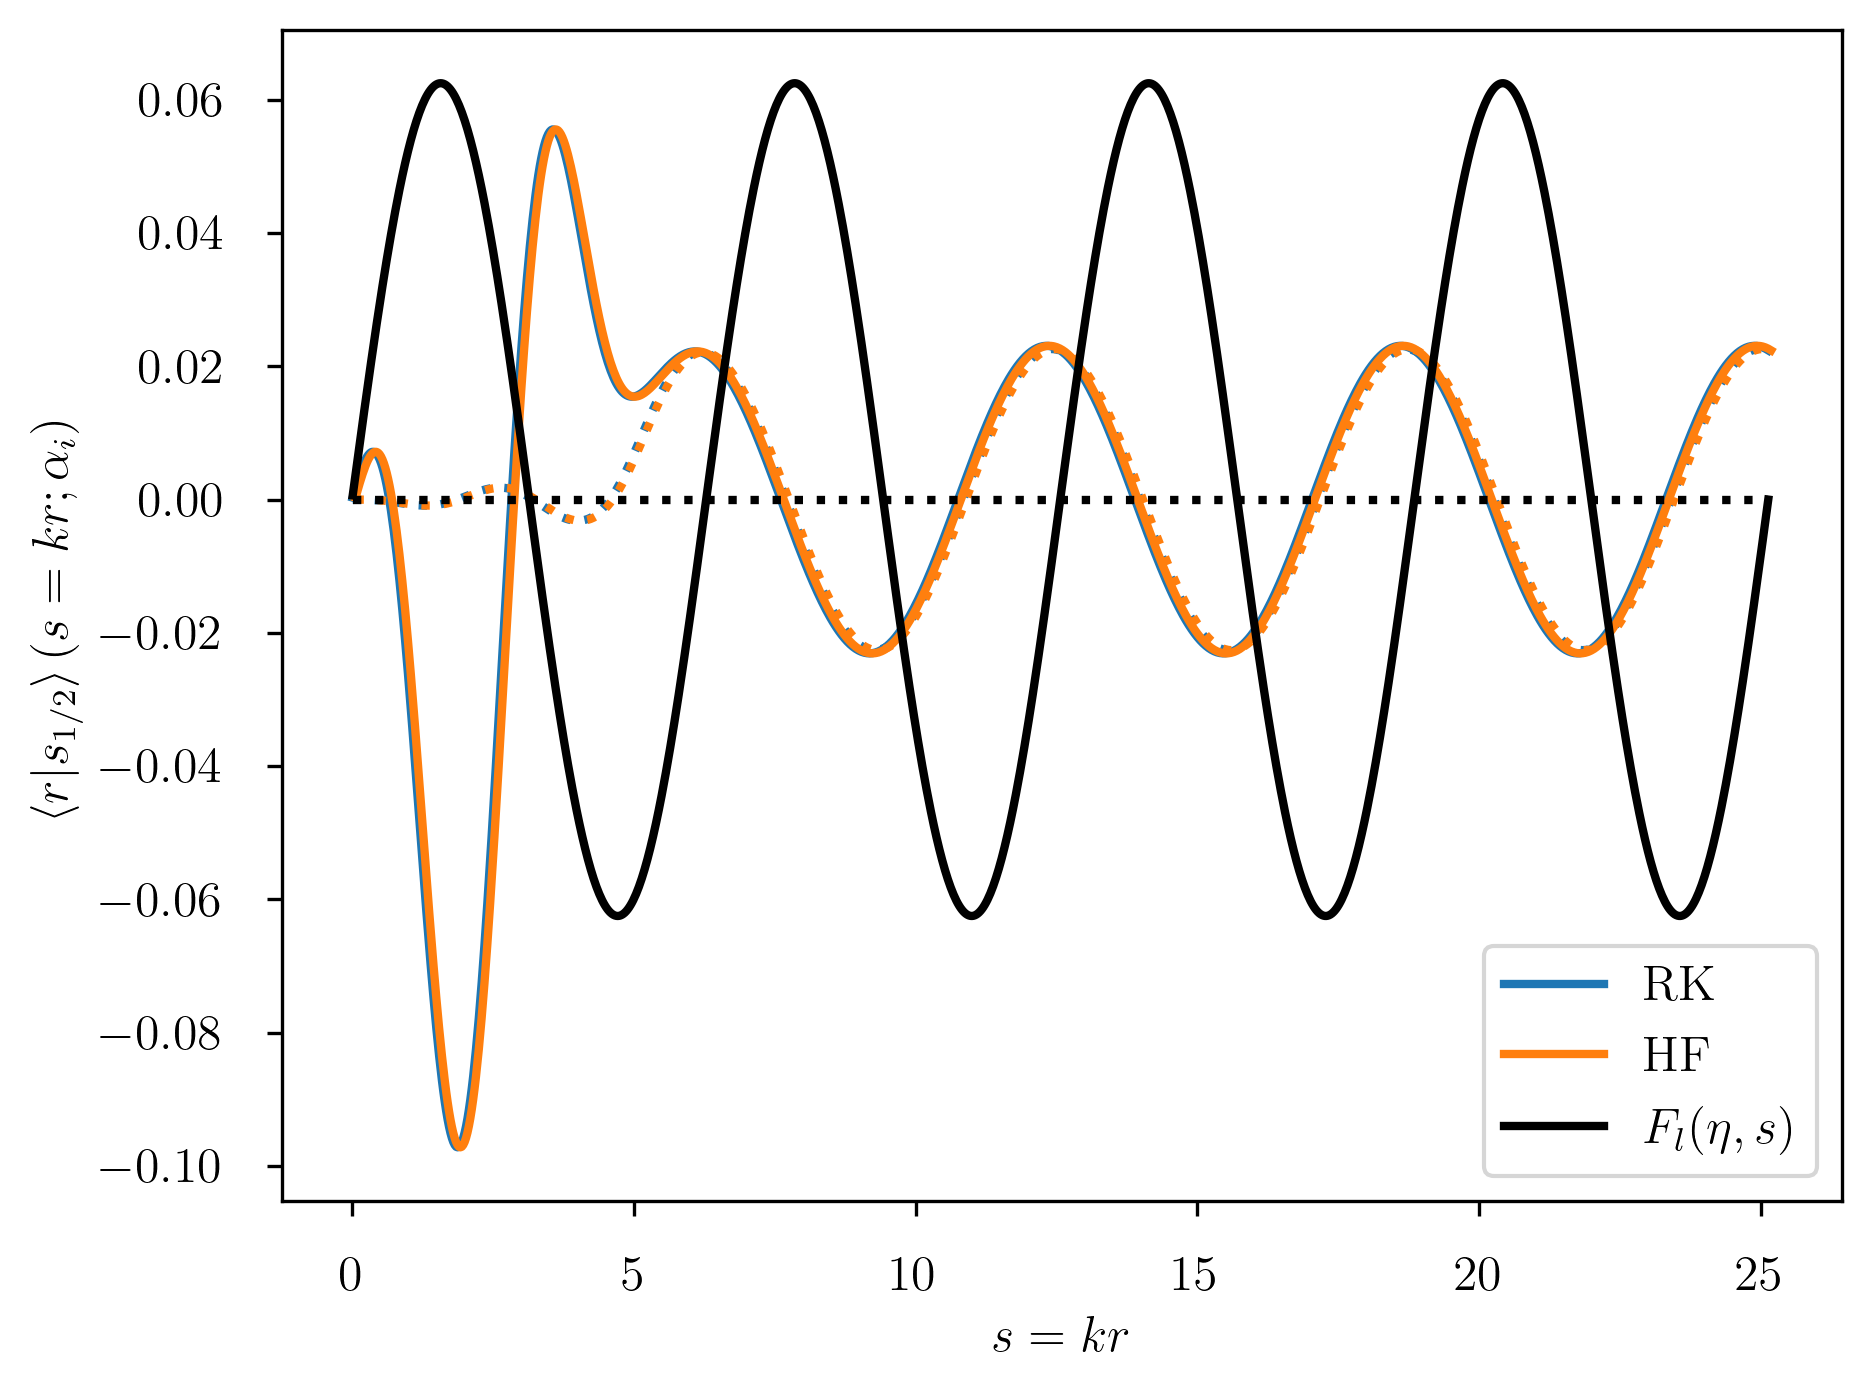

In [15]:
f = plt.figure(facecolor="white", dpi=300)
l = 0
i = 19
sample = train[i, :]
solns = sae.exact_wave_functions(sample)
z = hf_solns_up[i, l, :]
y = solns[l][0]
y /= np.trapz(np.absolute(y), s_mesh)
y -= free_solns[l, :]
p = plt.plot(s_mesh, y.real, label="RK")[0]
plt.plot(
    s_mesh,
    y.imag,
    ":",
    color=p.get_color(),
)
p = plt.plot(s_mesh + 0.05, z.real, label="HF")[0]
plt.plot(
    s_mesh + 0.05,
    z.imag,
    ":",
    color=p.get_color(),
)

plt.plot(s_mesh, free_solns[l, :].real, "k", label=r"$F_l(\eta, s)$")
plt.plot(s_mesh, free_solns[l, :].imag, ":k")

plt.xlabel(r"$s = kr$")
plt.ylabel(r"$\braket{  r | s_{1/2}}(s=kr; \alpha_i)$")
plt.legend()
plt.tight_layout()

## Discover the Active Subspace

In [16]:
from scipy.spatial import kdtree

In [17]:
# pre process training data
train_transformed = [ forward_pspace_transform(sample) for sample in train]
train_mean = np.mean(train_transformed, axis=0)
train_pp = (train_transformed - train_mean) / (
    log_energy_bounds[:, 1] - log_energy_bounds[:, 0]
)
train_pp[:, frozen_params] = 0

def pre_process(sample):
    x = (forward_pspace_transform(sample) - train_mean) / (
        log_energy_bounds[:, 1] - log_energy_bounds[:, 0]
    )
    x[frozen_params] = 0
    return x

/tmp/ipykernel_82357/1235986136.py:4: RuntimeWarning: divide by zero encountered in divide
  train_pp = (train_transformed - train_mean) / (


In [18]:
# construct a KD-tree for for the pre processed training points
tree = kdtree.KDTree(train_pp)

/tmp/ipykernel_82357/2057503109.py:2: DeprecationWarning: Please use `KDTree` from the `scipy.spatial` namespace, the `scipy.spatial.kdtree` namespace is deprecated.
  tree = kdtree.KDTree(train_pp)


In [19]:
train.shape

(10000, 17)

In [20]:
k = 100
lcut = 2

In [26]:
gradient_vector_samples = np.zeros(
    (train.shape[0] * (lcut * 4 -1 ), train[:, unfrozen_mask].shape[1]), dtype=np.double
)

for i in range(100):
    sample = train[i, :]
    ds, idxs = tree.query(pre_process(sample), k=k)

    max_delta_idxs = np.zeros((lcut * 4 - 2), dtype=np.int32)
    max_func_deriv = np.zeros((lcut * 4 - 2), dtype=np.complex128)

    phi_i_up = hf_solns_up[i, :lcut, :]
    phi_i_down = hf_solns_down[i, :lcut-1, :]

    for d, j in zip(ds, idxs):
        # numerator is \int ds phi_i^dagger (U_j(s) - U_i(s)) \phi_j
        phi_j_up = hf_solns_up[j, :lcut, :]
        phi_j_down = hf_solns_down[j, :lcut-1, :]

        func_deriv_up = (
            np.trapz(
                phi_j_up
                * (pot_terms_up[j, :lcut, :] - pot_terms_up[i, :lcut, :])
                * phi_j_up,
                s_mesh,
                axis=1,
            )
            / d
        )
        func_deriv_down = (
            np.trapz(
                phi_j_down
                * (pot_terms_down[j, :lcut-1, :] - pot_terms_down[i, :lcut-1, :])
                * phi_j_down,
                s_mesh,
                axis=1,
            )
            / d
        )
        func_deriv = np.hstack(
            [
                func_deriv_down.real,
                func_deriv_up.real,
                func_deriv_down.imag,
                func_deriv_up.imag,
            ]
        )
        print(func_deriv)
        mask = np.absolute(max_func_deriv) < np.absolute(func_deriv)
        max_func_deriv[mask] = func_deriv[mask]
        max_delta_idxs[mask] = j

    # TODO handle sign issue - gradient points up
    gradient_vector_samples[i : i + (lcut * 4-2), :] = [
        (train_pp[x, unfrozen_mask] - train_pp[i, unfrozen_mask])
        * np.sign(y)
        / np.sqrt(
            np.dot(
                train_pp[x, unfrozen_mask] - train_pp[i, unfrozen_mask],
                train_pp[x, unfrozen_mask] - train_pp[i, unfrozen_mask],
            )
        )
        for x, y in zip(max_delta_idxs, max_func_deriv)
    ]

/tmp/ipykernel_82357/1235986136.py:10: RuntimeWarning: divide by zero encountered in divide
  x = (forward_pspace_transform(sample) - train_mean) / (
/tmp/ipykernel_82357/2487928685.py:21: RuntimeWarning: invalid value encountered in divide
  np.trapz(
/tmp/ipykernel_82357/2487928685.py:31: RuntimeWarning: invalid value encountered in divide
  np.trapz(
/tmp/ipykernel_82357/2487928685.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient_vector_samples[i : i + (lcut * 4-2), :] = [


[nan nan nan nan nan nan]
[-0.00497603 -0.02628487 -0.00634392  0.000144    0.00545568  0.00022261]
[-0.00019573 -0.01052977 -0.00033022 -0.00045647  0.02176609 -0.00024324]
[-0.02425866 -0.03024363 -0.02444753 -0.00022487  0.01292951  0.00019709]
[-0.01405802 -0.00837125 -0.01449139 -0.00105853  0.01114353 -0.0005811 ]
[-0.00944231 -0.01854861 -0.00825375  0.00333696  0.00450786  0.00386162]
[-1.46469884e-03 -7.82181476e-03 -1.82141409e-03 -9.86955658e-05
  1.21161290e-02 -6.49909502e-05]
[-0.00025379 -0.02143125 -0.00046788 -0.00039371  0.01189591 -0.00025145]
[-0.03371948 -0.0448113  -0.03462922 -0.00319478  0.00789257 -0.00286568]
[-0.05226593 -0.05326193 -0.0539601  -0.00231207 -0.00114123 -0.00176455]
[-0.03559274 -0.05829643 -0.03539761  0.0005724   0.00845371  0.00041731]
[-1.31354302e-02 -7.91778051e-03 -1.28986154e-02 -1.94079701e-05
  1.05356424e-02  3.24720807e-04]
[-0.03817641 -0.05570214 -0.03967938 -0.00522195  0.00595208 -0.00464216]
[-0.00310387 -0.0126633  -0.0026252 

[0.00309714 0.06887362 0.00569147 0.01665626 0.01649342 0.01677619]
[ 0.0107348   0.01039869  0.00972582 -0.00309776  0.00125915 -0.00216796]
[ 0.04448063  0.03456288  0.05459684  0.04324431 -0.01689014  0.04276214]
[-0.01205057  0.05143941 -0.0106884   0.01236246  0.01748076  0.01289205]
[-0.00205173  0.00264549 -0.00108184  0.006323    0.00727019  0.00847658]
[0.01067788 0.07034448 0.01251062 0.01325983 0.01111103 0.01318053]
[-0.01211922  0.15034622  0.01512836  0.07097498  0.01579488  0.09157643]
[-0.0191095   0.12322706 -0.02389138  0.01507663  0.1046686   0.02435825]
[0.01583807 0.07327248 0.01864206 0.0134474  0.01183365 0.01339796]
[-0.036147   -0.01362318 -0.03733011 -0.00224524  0.00356682 -0.0020116 ]
[-0.03012763  0.01184103 -0.03109224  0.00149428  0.01093723  0.00183226]
[-0.01795653  0.04296648 -0.01733097  0.00817185  0.01554807  0.00863218]
[0.00441044 0.0693998  0.00699443 0.01619062 0.01634459 0.01649535]
[0.00969379 0.07287162 0.01244184 0.01490343 0.01359003 0.0150

[-0.01680175  0.01042069 -0.01771793 -0.00294168  0.00932934 -0.00245352]
[-0.02270673 -0.01397618 -0.02407853 -0.00385666  0.00052968 -0.00374897]
[-0.02041515  0.02575137 -0.01813048  0.00928607  0.01926321  0.01010973]
[-0.02461524 -0.00747559 -0.02587398 -0.00434275  0.00409166 -0.00395995]
[-0.02459821 -0.00341993 -0.02579541 -0.00277348  0.00672331 -0.00225574]
[-2.36759474e-03  2.49076476e-02 -4.91349251e-03  1.31453150e-04
  1.32789111e-01  7.62276225e-04]
[-0.02471843 -0.01268376 -0.02608883 -0.00401886  0.00234851 -0.00375876]
[-0.01822674 -0.00185981 -0.01969178 -0.0046224   0.00257274 -0.00436078]
[-0.02765416  0.00082239 -0.02804108 -0.00090371  0.01049121 -0.00020318]
[-0.02635449 -0.00997766 -0.02758685 -0.0044316   0.00329908 -0.00401463]
[-0.02440681 -0.01281338 -0.02579054 -0.00391183  0.00224537 -0.00368794]
[-0.01003811 -0.02827068 -0.01211999  0.00087522  0.01302311  0.00266612]
[-0.00881197 -0.0035442  -0.00848528  0.0048419   0.00170437  0.0040494 ]
[ 0.00033936 

[-0.0241406  -0.0258856  -0.02513415 -0.00166026 -0.00195574 -0.00139753]
[ 0.0056356   0.0061655   0.00546291 -0.0012009  -0.00087387 -0.00105023]
[0.00196927 0.00285188 0.00206426 0.000571   0.00041272 0.00073595]
[-0.02162503 -0.03013484 -0.02571707 -0.01279699 -0.00692492 -0.01255845]
[-0.00350605 -0.00220479 -0.00327586  0.0016671   0.0012529   0.001934  ]
[-1.24832543e-04  1.82769873e-04 -3.89679871e-05 -3.69183118e-04
 -2.21862372e-04 -3.45886312e-04]
[ 0.00292623 -0.0043148   0.00102031 -0.00924815 -0.00844259 -0.01040988]
[-0.00474955 -0.00326679 -0.0044418   0.00122507  0.0010531   0.0014758 ]
[-6.83241003e-03 -5.36546606e-03 -6.97480324e-03  6.10075719e-05
  3.89842188e-05  2.14179642e-04]
[-0.03868486 -0.05704319 -0.03760465  0.00775812 -0.00179777  0.00925854]
[-0.00118064 -0.00024749 -0.0010161   0.00021257  0.0003326   0.00038761]
[-2.79793100e-02 -2.86643463e-02 -2.84860464e-02 -3.08444659e-04
 -4.52067542e-04 -4.13761694e-05]
[0.00085161 0.00202528 0.00101898 0.0005841

[-0.00972805 -0.03633094 -0.01563781 -0.00572673 -0.00529494 -0.00633742]
[-0.01395686 -0.01418703 -0.01427428 -0.00245127 -0.00265276 -0.00223405]
[0.00085688 0.00432641 0.00153354 0.00022063 0.00010156 0.00035654]
[-0.00275431 -0.00467735 -0.00499399 -0.00613863 -0.00590558 -0.00591406]
[-2.81172301e-03 -1.84742364e-03 -3.10406097e-03 -1.26776600e-03
  9.58729124e-06 -1.15682807e-03]
[ 0.00815158  0.00774704  0.00788566 -0.00274555 -0.00213014 -0.00249511]
[-0.00274503 -0.00019211 -0.00199933  0.00081469  0.00075841  0.00081998]
[-4.47570624e-03 -2.54639161e-03 -3.80089876e-03  5.17253891e-05
  3.62925429e-06  2.96600615e-05]
[-0.00222693 -0.00019259 -0.00224199 -0.00080861  0.00075657 -0.00073661]
[7.04141937e-03 1.08684965e-02 7.43424336e-03 7.85567873e-05
 9.36165662e-04 2.75536293e-04]
[-0.02185924 -0.05013341 -0.02677018 -0.01153925 -0.00319976 -0.01043895]
[-4.63162072e-03 -2.04402581e-03 -4.43763230e-03 -1.01659704e-04
  1.39638015e-03  1.68074651e-05]
[ 0.00437465  0.00429436

[ 7.12706654e-04 -7.51303560e-04  1.22514285e-05 -2.87895469e-03
 -3.14674903e-03 -2.97658239e-03]
[ 2.54469010e-03  2.95817300e-03  2.63058083e-03  6.32534825e-05
 -4.78465493e-05  6.31761032e-05]
[ 0.01385328  0.01356935  0.01378586 -0.00156778 -0.00190516 -0.00177416]
[0.00816933 0.00826903 0.00820149 0.00061152 0.00077005 0.00056583]
[ 0.00741295  0.00721837  0.00747589 -0.00017727 -0.00048943 -0.00023816]
[-0.02984839 -0.02858036 -0.0334924  -0.01402589 -0.01144525 -0.01266812]
[-0.00819384 -0.01032883 -0.00947667 -0.00581429 -0.00581122 -0.00596814]
[0.00217816 0.0025778  0.00242622 0.00163864 0.00157611 0.00165223]
[0.0026363  0.00320784 0.00297439 0.00107071 0.00084765 0.00118385]
[-0.00243999 -0.00496071 -0.0038172  -0.00312359 -0.00385395 -0.00340169]
[-0.00268741 -0.00228804 -0.00247127  0.0027088   0.00264649  0.00273493]
[ 0.00635488  0.00538722  0.00576986 -0.00140174 -0.00140901 -0.00147965]
[-0.0020264  -0.08669092  0.00483175  0.03264845 -0.01602196  0.03127013]
[-7.25

[-0.02461134 -0.0145679  -0.02574681 -0.00470985 -0.00099351 -0.00449479]
[-0.00606489  0.10772335 -0.00841152  0.0019095   0.07136108  0.00306503]
[-0.00905055  0.17966177 -0.01340371  0.00301683  0.05123043  0.00638566]
[-0.0133825   0.06261156 -0.01188708  0.00524146  0.01088869  0.00522699]
[-0.02919271  0.01675263 -0.03006079 -0.00135325  0.00672713 -0.00104858]
[-0.02716323  0.04039888 -0.02641009  0.00271902  0.01107155  0.00298958]
[-0.02743028  0.03512659 -0.02727312  0.00186081  0.01225836  0.00247983]
[-0.02791046  0.03217843 -0.02865872  0.00062242  0.01005026  0.00102593]
[-3.67498587e-02  1.95086879e-03 -3.70370498e-02 -1.58844509e-04
  6.87008438e-03  5.22239502e-07]
[ 0.04343136  0.08055903  0.05359961  0.03343597 -0.03637171  0.03226321]
[nan nan nan nan nan nan]
[-0.00821018  0.0052738  -0.00710704  0.00065084  0.01083044  0.00114966]
[ 0.00090872 -0.02180458  0.00076262  0.00107501 -0.00823641  0.00060272]
[-0.0014977   0.05498763 -0.00226887  0.00018907  0.03120713 

[ 0.00112097 -0.00119735  0.00255249  0.00727988  0.00517699  0.00791597]
[0.00986778 0.00801351 0.01161264 0.00718155 0.00563531 0.00772069]
[0.01056391 0.00930512 0.0128679  0.00779466 0.00584329 0.00833148]
[ 0.00124438 -0.00166405  0.00151516  0.0042077   0.00234128  0.00470008]
[-0.00311763 -0.0051306  -0.0015121   0.00708988  0.00476762  0.00735001]
[-0.03138859 -0.04268319 -0.02795993  0.01039589  0.00317272  0.0159877 ]
[0.01389616 0.0150342  0.0178999  0.00987888 0.00750897 0.00989704]
[-0.02873088 -0.04454783 -0.03221356 -0.00233192  0.00107527  0.0034927 ]
[-0.00406609 -0.01021696 -0.00752844 -0.00509504 -0.00343821 -0.00440947]
[-0.00237736 -0.00511617 -0.00177564  0.00464716  0.00288946  0.00501723]
[-0.01360851 -0.0166271  -0.01384569 -0.00167512 -0.00257207 -0.00034479]
[0.01001303 0.00710522 0.01078447 0.00441121 0.0022901  0.00481373]
[0.02131812 0.01942134 0.02347703 0.00597849 0.00419454 0.00636262]
[0.01233504 0.01134233 0.01355856 0.00202384 0.00016722 0.0020115 ]


[-0.00103723 -0.03526042 -0.00115057 -0.00072213 -0.00486954 -0.00073926]
[-0.0261033  -0.10061044 -0.0270539  -0.00530775  0.00021728 -0.00562827]
[-0.00018027  0.01800228 -0.00017134  0.00016749  0.00617033  0.00026565]
[-0.006682   -0.02265515 -0.00648368 -0.0006592  -0.00099186 -0.00097757]
[-0.00973878 -0.03696874 -0.01004632 -0.00202918 -0.00380604 -0.00247838]
[-2.46619276e-05 -4.30269214e-03 -2.53876407e-05 -1.22187030e-04
 -3.37129903e-04 -1.32943085e-04]
[-0.01165595 -0.02272008 -0.01130522 -0.00199248 -0.00240435 -0.00201172]
[-0.00846586 -0.01507287 -0.00829187 -0.00072161 -0.00093468 -0.00079955]
[ 0.00247285  0.00345979  0.00220107  0.00042365 -0.00649889  0.00022282]
[ 2.26536694e-03 -2.26901409e-03  1.89257024e-03  2.18178155e-04
 -7.68264971e-03  5.68317839e-05]
[-0.0170292  -0.06587116 -0.01790385 -0.00499768 -0.00417795 -0.00553382]
[0.0008419  0.01246843 0.00085516 0.00022423 0.0046334  0.00023821]
[0.00431392 0.01101742 0.00489895 0.00067951 0.00032517 0.00070802]


[-2.91376467e-04 -1.25919480e-02 -2.76914970e-04  2.85402397e-05
 -3.49657702e-03  2.30369992e-05]
[ 6.33286543e-05  8.16019173e-03  2.75110681e-05 -8.56645247e-05
  4.22317483e-03 -8.01165896e-05]
[-0.00839619 -0.05804877 -0.00922264 -0.00124089  0.00042171 -0.00161471]
[-0.02036061 -0.06941978 -0.02043108 -0.00193628 -0.00129519 -0.00172419]
[-0.00235233 -0.0251737  -0.00281962  0.00035429 -0.00397687  0.00013862]
[-5.72605561e-03 -3.04112897e-02 -5.49472547e-03  2.82871836e-04
 -5.03241954e-04  5.59575152e-05]
[-0.00059901 -0.03421592 -0.00069374 -0.00011122 -0.00028522 -0.00012727]
[-0.01005768 -0.05902556 -0.01064743 -0.00230317 -0.00601069 -0.00250254]
[-0.00458062 -0.0057337  -0.00415504  0.00044215  0.00415492  0.0005951 ]
[0.00136251 0.00500227 0.00222528 0.0003443  0.00030776 0.00041189]
[-0.01260985 -0.04738019 -0.01275076 -0.00168042  0.00147862 -0.00155787]
[-3.39804051e-02 -7.53935652e-02 -3.44024038e-02  3.67412359e-04
 -2.62280477e-03  7.21172183e-05]
[-1.29726849e-02 -

In [22]:
U, S, Vh = np.linalg.svd(gradient_vector_samples.T, full_matrices=False)
print(U.shape, S.shape, Vh.shape)

(15, 15) (15,) (15, 70000)


In [23]:
# we have to rotate and stretch, not just rotate
U = U @ np.diag(S)

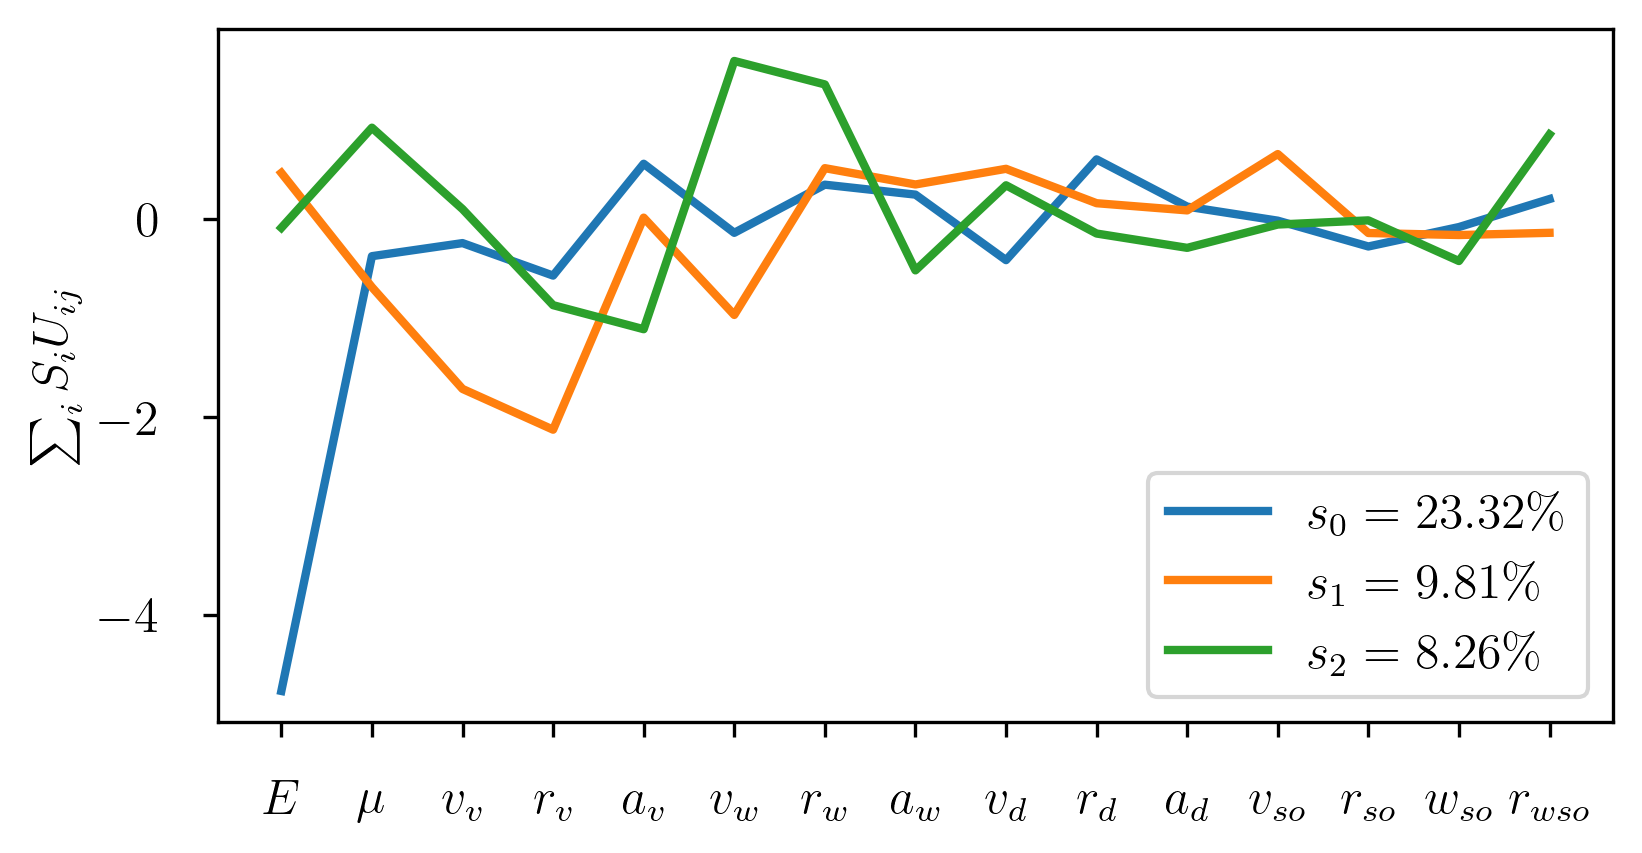

In [24]:
# vectors in param space with largest variance of gradient wrt smatrix training set
f, ax = plt.subplots(facecolor="white", figsize=(6,3), dpi=300)
for i in range(3):
    s = S[i] ** 2 / np.sum(S**2) * 100
    plt.plot(list(range(15)), U[:,i], label=f"$s_{i} = {s:.2f}\%$")
ax.xaxis.set_ticks(list(range(15)))
ax.xaxis.set_ticklabels(param_labels[unfrozen_mask])
#plt.ylim([-1.0, 1.0])
plt.ylabel(r"$ \sum_i S_{i} U_{ij} $")
plt.legend()
plt.savefig("active_subspace_vectors.pdf")

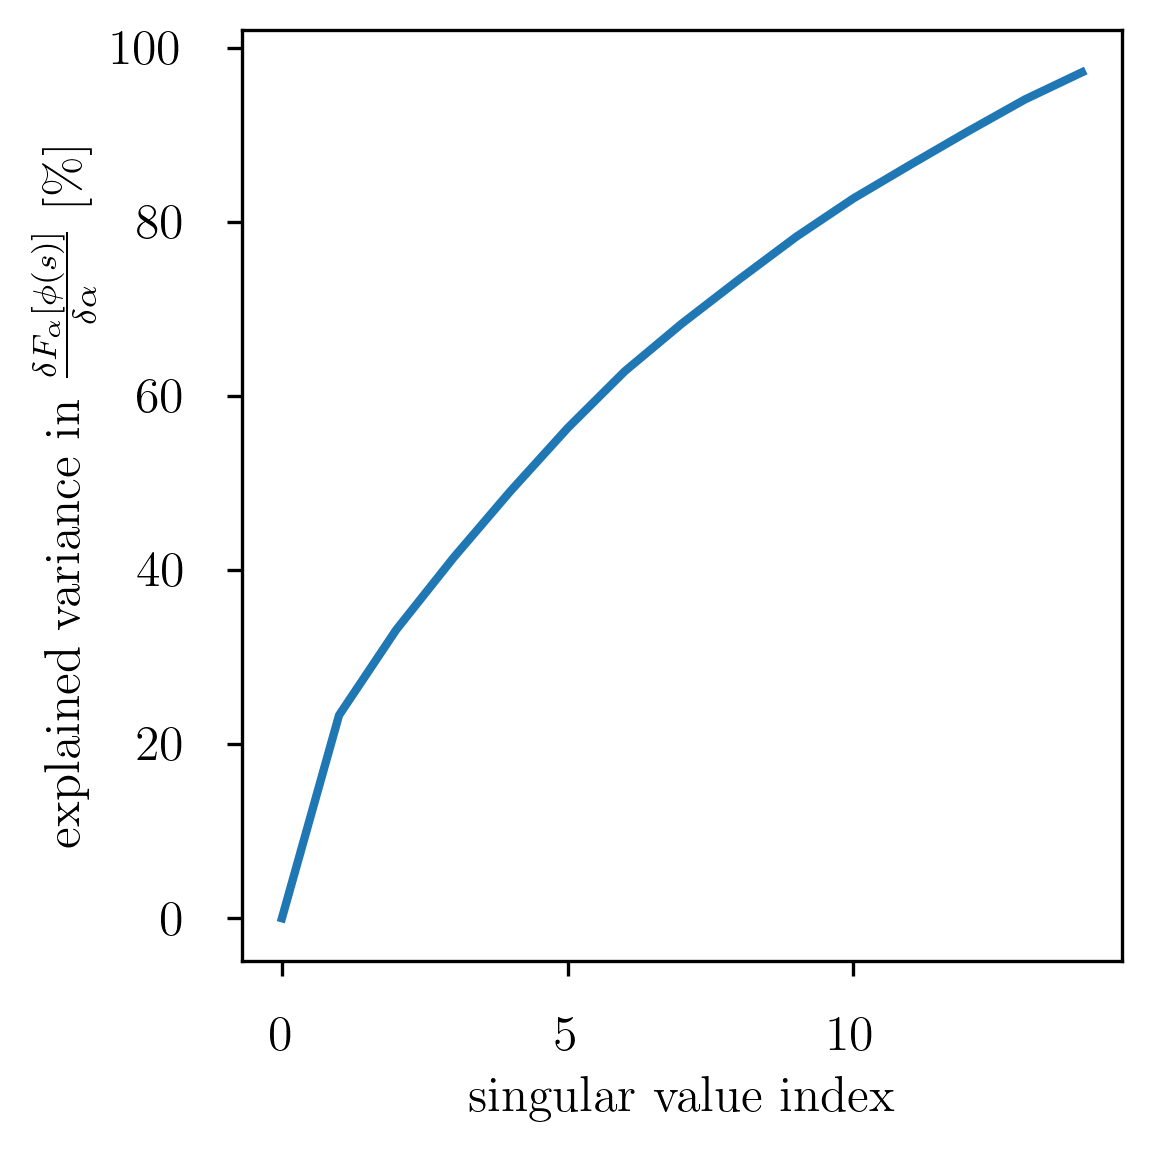

In [25]:
f = plt.figure(facecolor="white", figsize=(4,4), dpi=300)
plt.plot(
    list(range(len(S))), 
    100*np.array([np.sum(S[:i]**2) for i in range(len(S))]) / np.sum(S**2)
)
#plt.ylim([1e-8,100])
plt.xlabel("singular value index")
plt.ylabel(r"explained variance  in $\frac{\delta F_{\alpha}[\phi(s)]}{\delta \alpha}$ [\%]")
plt.tight_layout()
plt.savefig("active_subspace_svs.pdf")

## Construct a kd-tree for training points rotated into the active subspace

In [ ]:
class OnlineActiveSubspace:
    """
    Everything needed to project into, and find nearest neighbors in, the active subspace
    """

    def __init__(
        self,
        ndims_total: int,
        ndims_active: int,
        U: np.array,
        train,
        forward_pspace_transform,
        backward_pspace_transform,
        bounds,
        frozen_params,
    ):
        self.frozen_params = frozen_params.copy()
        self.unfrozen_mask = np.logical_not(self.frozen_params)
        self.ndims_total = ndims_total
        self.ndims_active = ndims_active
        self.Utrans = U.T
        self.Uinv = np.linalg.inv(self.Utrans)
        self.forward_pspace_transform = forward_pspace_transform
        self.backward_pspace_transform = backward_pspace_transform
        self.train = train
        self.bounds = np.vstack(
            [
                bounds[:, 0],
                bounds[:, 1],
            ]
        ).T
        self.bounds_transformed = np.vstack(
            [
                self.forward_pspace_transform(self.bounds[:, 0]),
                self.forward_pspace_transform(self.bounds[:, 1]),
            ]
        ).T

        self.train_mean = self.forward_pspace_transform(np.mean(train, axis=0))
        self.train_as = np.array([self.to_AS(sample) for sample in train])
        self.active_subspace_kdtree = kdtree.KDTree(self.train_as)

        self.prepro_bounds = np.vstack(
            [self.pre_process(bounds[:, 0]), self.pre_process(bounds[:, 1])]
        ).T

    def update_train(self):
        # update train_as and train
        # update bounds
        # update trees
        pass

    def pre_process(self, sample):
        """
        scale and center point on parameter space (wrt to training set)
        """
        x = (self.forward_pspace_transform(sample) - self.train_mean) / (
            self.bounds_transformed[:, 1] - self.bounds_transformed[:, 0]
        )
        x[self.frozen_params] = 0
        return x

    def post_process(self, sample):
        """
        Un-scale and un-center point on scaled and centered parameter space
        """
        x = self.backward_pspace_transform(
            sample * (self.bounds_transformed[:, 1] - self.bounds_transformed[:, 0])
            + self.train_mean
        )
        x[self.frozen_params] = self.bounds[self.frozen_params, 0]
        return x

    def to_AS(self, sample):
        """
        Convert from parameter space to active subspace
        """
        return self.Utrans @ self.pre_process(sample)[self.unfrozen_mask]

    def from_AS(self, point):
        """
        Convert from active subspace to parameter space
        """
        y = np.zeros((self.ndims_total))
        y[self.unfrozen_mask] = self.Uinv @ point
        y[self.frozen_params] = self.bounds[self.frozen_params, 0]
        return self.post_process(y)

    def get_neighbors(self, sample, knn=1):
        """
        Get nearest neighboring training points on active subspace to sample
        """
        dists, idxs = self.active_subspace_kdtree.query(self.to_AS(sample), k=knn)
        return dists, idxs

    def get_bbox(self, neighborhood):
        """
        Return bounding box (in centered and scaled space) containing a training neighborhood
        """
        neighbors = self.train[neighborhood]
        size = neighbors.shape[0]
        bbox = np.tile(self.pre_process(neighbors[0, :]).T, (2, 1)).T
        for i in range(size):
            neighbor = self.pre_process(neighbors[i, :])
            mask_lower = neighbor <= bbox[:, 0]
            mask_upper = neighbor > bbox[:, 1]
            bbox[mask_lower, 0] = neighbor[mask_lower]
            bbox[mask_upper, 1] = neighbor[mask_upper]

        return bbox

    def get_active_bbox(self, neighborhood):
        """
        Return bounding box (in centered and scaled space) containing a training neighborhood
        """
        neighbors = self.train_as[neighborhood, :]
        size = neighbors.shape[0]
        bbox = np.tile(neighbors[0, :].T, (2, 1)).T
        for i in range(size):
            neighbor = neighbors[i, :]
            mask_lower = neighbor <= bbox[:, 0]
            mask_upper = neighbor > bbox[:, 1]
            bbox[mask_lower, 0] = neighbor[mask_lower]
            bbox[mask_upper, 1] = neighbor[mask_upper]

        return bbox

    def sample_from_active_neighborhood(
        self, tangent_point, neigborhood_size, nsamples, seed=None
    ):
        """
        Sample points in parameter space from the training neighborhood belonging
        to tangent_point
        """
        dists, neighborhood = self.get_neighbors(tangent_point, knn=neigborhood_size)
        bbox = self.get_active_bbox(neighborhood)
        return np.array(
            [
                self.from_AS(sample)
                for sample in rose.training.latin_hypercube_sample(nsamples, bbox, seed)
            ]
        )

    def sample_from_neighborhood(
        self, tangent_point, neigborhood_size, nsamples, seed=None
    ):
        """
        Sample points in parameter space from the training neighborhood belonging
        to tangent_point
        """
        dists, neighborhood = self.get_neighbors(tangent_point, knn=neigborhood_size)
        bbox = self.get_bbox(neighborhood)
        return np.array(
            [
                self.post_process(sample)
                for sample in rose.training.latin_hypercube_sample(nsamples, bbox, seed)
            ]
        )

    def sample(self, nsamples, seed=None):
        """
        Sample points in parameters space
        """
        return np.array(
            [
                self.post_process(sample)
                for sample in rose.training.latin_hypercube_sample(
                    nsamples, self.prepro_bounds, seed
                )
            ]
        )

    def save(self, fpath):
        with open(fpath, "wb") as f:
            pickle.dump(self, f)

    @classmethod
    def load(obj, fpath):
        with open(fpath, "rb") as f:
            asubs = pickle.load(f)
        return asubs

In [ ]:
active_subspace = OnlineActiveSubspace(
    ndims_total=17,
    ndims_active=15,
    U=U,
    train=train,
    forward_pspace_transform=forward_pspace_transform,
    backward_pspace_transform=backward_pspace_transform,
    bounds=bounds,
    frozen_params=frozen_params,
)

In [ ]:
from rose.training import compare_phase_shifts, compare_partial_waves

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), dpi=600)
fig.patch.set_facecolor("white")

# samples in the training space that are close together in the active subspace
# produce very similar responses (e.g. s-matrix elements and phase shifts)

i = 0
# get nearest active subspace neighbors to first training sample
dists, idxs = active_subspace.get_neighbors(test[i], knn=5)
print([(d, i) for d, i in zip(dists, idxs)])

# get phase shifts of neighbors to first training sample
ps0 = sae.exact_phase_shifts(test[i])
psneighbor = sae.exact_phase_shifts(train[idxs[0]])

compare_phase_shifts(
    [ps0, psneighbor], ["sample point", "nearest neighbor"], fig, ax1, ax2
)
ax1.set_ylim([-np.pi / 2, np.pi / 2])
ax2.set_ylim([-np.pi / 2, np.pi / 2])
fig.suptitle("nearest neighbors on active subspace")
plt.tight_layout()
plt.savefig("nn_active_phase_shifts.pdf")

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), dpi=600)
fig.patch.set_facecolor("white")

ps0 = sae.exact_wave_functions(test[i])
psneighbor = sae.exact_wave_functions(train[idxs[0]])

compare_partial_waves(
    s_mesh, [ps0[:3], psneighbor[:3]], ["sample point", "nearest neighbor"], fig, ax1, ax2
)
plt.savefig("nn_active_wvfxtns.pdf")

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), dpi=600)
fig.patch.set_facecolor("white")

# samples in the training space that are close together may not

# get nearest active subspace neighbors to first training sample
dists, idxs = tree.query( active_subspace.pre_process(test[i]), k=5)
print([(d, i) for d, i in zip(dists, idxs)])

# get phase shifts of neighbors to first training sample
ps0 = sae.exact_phase_shifts(test[i])
psneighbor = sae.exact_phase_shifts(train[idxs[0]])


compare_phase_shifts(
    [ps0, psneighbor], ["sample point", "nearest neighbor"], fig, ax1, ax2
)
ax1.set_ylim([-np.pi / 2, np.pi / 2])
ax2.set_ylim([-np.pi / 2, np.pi / 2])
fig.suptitle("nearest neighbors on parameter space")
plt.tight_layout()
plt.savefig("nn_param_space_phase_shifts.pdf")

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), dpi=300)
fig.patch.set_facecolor("white")

ps0 = sae.exact_wave_functions(test[i])
psneighbor = sae.exact_wave_functions(train[idxs[0]])

compare_partial_waves(
    s_mesh, [ps0[:3], psneighbor[:3]], ["sample point", "nearest neighbor"], fig, ax1, ax2
)
plt.savefig("nn_param_space_wvfxtns.pdf")

## Evenly sample a set of points on the parameter space to act as tangent points

In [ ]:
# we can do this by randomly selecting a set of points on the original param space
ntangents = 750
tangent_points = active_subspace.sample(ntangents, seed=1233)
tangent_points_AS = np.array([active_subspace.to_AS(sample) for sample in tangent_points])
tangent_point_tree = kdtree.KDTree(tangent_points_AS)

def closest_tangent_point(sample):
    return tangent_point_tree.query(active_subspace.to_AS(sample))

## Test out a single tangent space

In [ ]:
tangent_point = tangent_points[0]
size=50
dists, neighborhood = active_subspace.get_neighbors(tangent_point, knn=size)

In [ ]:
t = active_subspace.sample_from_active_neighborhood(tangent_point, size, 1000, seed=99)
test_points = []
test_points.append(tangent_point)
for pt in t:
    _, idx = tangent_point_tree.query( active_subspace.to_AS(pt), k=1 )
    if idx == 4:
        test_points.append(pt)
test_points = np.array(test_points)
print(test_points.shape)

In [ ]:
int_test = rose.koning_delaroche.EnergizedKoningDelaroche(
    training_info=train[neighborhood,:],
    explicit_training=True,
    n_basis=15,
    l_max=l_max,
    rho_mesh=s_mesh,
)

In [ ]:
f = plt.figure(facecolor="white", dpi=300, figsize=(4,3))
for sample in test_points:
    p = plt.plot(s_mesh, int_test.interactions[9][1].tilde(s_mesh, sample), alpha=0.5)[
        0
    ]
    plt.plot(
        s_mesh,
        int_test.interactions[9][1].tilde_emu(s_mesh, sample),
        ":",
        alpha=0.5,
        color=p.get_color(),
    )

legend_styles = [
    Line2D([0], [0], color="k", linestyle=":", alpha=0.5),
    Line2D([0], [0], color="k", alpha=0.5),
]
plt.legend(legend_styles, ["EIM", "exact"])


plt.ylabel(r"$U(s; \alpha)$")
plt.xlabel(r"$s = kr$")
plt.xscale("log")
plt.tight_layout()
plt.savefig("EIM_neighborhood_100_tan500_train10k.pdf")

In [ ]:
nbasis=15
def make_bases(ids, interactions):
    bases = []
    for l in range(l_max+1):
        bup = rose.CustomBasis(
            hf_solns_up[ids, l, :].T,
            free_solns[l, :],
            s_mesh,
            nbasis,
            solver=rose.SchroedingerEquation(
                interactions.interactions[l][0],
                s_0=s_0,
                domain=domain,
            ),
            use_svd=True,
            scale=False,
            subtract_phi0=False,
        )
        if l == 0:
            bases.append([bup])
        else:
            bdown = rose.CustomBasis(
                hf_solns_down[ids, l-1, :].T,
                free_solns[l, :],
                s_mesh,
                nbasis,
                solver=rose.SchroedingerEquation(
                    interactions.interactions[l][1],
                    s_0=s_0,
                    domain=domain,
                ),
                use_svd=True,
                scale=False,
                subtract_phi0=False,
            )
            bases.append([bup, bdown])
    return bases

In [ ]:
sae_test = rose.ScatteringAmplitudeEmulator(
            interaction_space=int_test,
            bases=make_bases(neighborhood, int_test),
            angles=angles,
            s_0=s_0,
            l_max=l_max,
)

In [ ]:
if False:
    sae_test_t = rose.ScatteringAmplitudeEmulator.from_train(
        interaction_space=int_test,
        alpha_train=train[neighborhood,:],
        base_solver=rose.SchroedingerEquation(
            interactions.interactions[0][0],
            s_0=s_0,
            domain=domain,
        ),
        use_svd=True,
        scale=True,
        angles=angles,
        l_max=l_max,
        n_basis=10,
        s_mesh=s_mesh,
    )
    

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), dpi=600)
fig.patch.set_facecolor("white")

test_pt = test_points[0]
exact_wf = sae_test.exact_wave_functions(test_pt)
em_wf = sae_test.emulate_wave_functions(test_pt)

for i in range(len(exact_wf)):
    for j in range(len(exact_wf[i])):
        em_wf[i][j] *= exact_wf[i][j][100] / em_wf[i][j][100]

compare_partial_waves(
    s_mesh, [exact_wf[:3], em_wf[:3]], ["Runge-Kutta", "RBM"], fig, ax1, ax2
)
plt.tight_layout()
plt.savefig("exact_vs_em_wvfxnt.pdf")

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), dpi=600)
fig.patch.set_facecolor("white")

exact_wf  = sae_test.exact_phase_shifts(test_pt)
em_wf = sae_test.emulate_phase_shifts(test_pt)

compare_phase_shifts([exact_wf, em_wf], ["Runge-Kutta", "RBM"], fig, ax1, ax2)
ax1.set_ylim([-np.pi/2, np.pi/2])
ax2.set_ylim([-np.pi/2, np.pi/2])
plt.tight_layout()
plt.savefig("exact_vs_em_phase.pdf")

In [ ]:
exact_dsdo = []
for t in test_points: 
    exact_dsdo.append(sae_test.exact_dsdo(t))

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4), dpi=1000)
fig.patch.set_facecolor("white")
emulator = sae_test
styles = []
for i, sample in enumerate(test_points[:5]):
    x = angles * 180 / np.pi

    # HIFI
    y_exact = exact_dsdo[i]

    # emulated
    y_emu = sae_test.emulate_dsdo(sample)

    (p,) = ax.plot(x, y_emu, ":", alpha=0.5)
    ax.plot(x, y_exact, color=p.get_color(), alpha=0.5)
    styles.append(p)

legend_styles = [
    Line2D([0], [0], color="k", linestyle=":", alpha=0.5),
    Line2D([0], [0], color="k", alpha=0.5),
]
ax.legend(legend_styles, ["RBM", "Runge-Kutta"])
fig.legend(
    styles,
    [f"{x:.2f}" for x in ds],
    "upper left",
    shadow=True,
    ncol=5,
    bbox_to_anchor=[0.1,1.1, 0.1,0.1],
    title="active subspace distance"
)
plt.xlabel(r"$\theta$ [$^\circ$]", fontsize=12)
plt.ylabel(r"$\frac{d\sigma}{d\Omega}$ [mb/Sr]", fontsize=12)
plt.yscale("log")
plt.tight_layout()

## Test out a single tangent space in the pre-processed paramater space
As opposed to the active subspace

In [ ]:
tangent_points_pp = [ active_subspace.pre_process(sample) for sample in tangent_points]
tangent_point_tree = kdtree.KDTree(tangent_points_pp)

def closest_tangent_point(sample):
    return tangent_point_tree.query( active_subspace.pre_process(sample) )

def get_training_neighborhood(tangent_point, size):
    return tree.query( active_subspace.pre_process(tangent_point), k=size)

def sample_test_neighborhood(training_neighborhood, size, seed=None):
    tn_size = training_neighborhood.shape[0]
    bbox = np.tile( training_neighborhood[0,:].T, (2,1)).T
    for i in range(tn_size):
        mask_lower = training_neighborhood[i,:] <= bbox[:,0]
        mask_upper = training_neighborhood[i,:] > bbox[:,1]
        bbox[mask_lower,0] = training_neighborhood[i,mask_lower]
        bbox[mask_upper,1] = training_neighborhood[i, mask_upper]
    
    return rose.training.latin_hypercube_sample(size, bbox, seed)


In [ ]:
dists, neighborhood = get_training_neighborhood( tangent_point, size=size)

In [ ]:
int_test = rose.koning_delaroche.EnergizedKoningDelaroche(
    training_info=train[neighborhood,:],
    explicit_training=True,
    n_basis=20,
    l_max=l_max,
    rho_mesh=s_mesh,
)

In [ ]:
f = plt.figure(facecolor="white", dpi=300, figsize=(4,3))
for sample in test[test_neighborhood]:
    p = plt.plot(s_mesh, int_test.interactions[0][0].tilde(s_mesh, sample), alpha=0.5)[
        0
    ]
    plt.plot(
        s_mesh,
        int_test.interactions[0][0].tilde_emu(s_mesh, sample),
        ":",
        alpha=0.5,
        color=p.get_color(),
    )
legend_styles = [
    Line2D([0], [0], color="k", linestyle=":", alpha=0.5),
    Line2D([0], [0], color="k", alpha=0.5),
]
plt.legend(legend_styles, ["EIM", "exact"])

plt.ylabel(r"$U(s; \alpha)$")
plt.xlabel(r"$s = kr$")
plt.xscale("log")
plt.tight_layout()

In [ ]:
sae_test = rose.ScatteringAmplitudeEmulator.from_train(
    interaction_space=int_test,
    alpha_train=train[neighborhood,:],
    base_solver=rose.SchroedingerEquation.make_base_solver(s_0=s_0, domain=domain),
    l_max=l_max,
    angles=angles,
    use_svd=True,
    scale=True,
    s_mesh=s_mesh,
    n_basis=20,
)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), dpi=600)
fig.patch.set_facecolor("white")



test_pt = test[test_neighborhood[0]]
exact_wf = sae_test.exact_wave_functions(test_pt)
em_wf = sae_test.emulate_wave_functions(test_pt)

for i in range(len(exact_wf)):
    for j in range(len(exact_wf[i])):
        em_wf[i][j] *= exact_wf[i][j][500] / em_wf[i][j][500]


compare_partial_waves(
    s_mesh, [exact_wf[:3], em_wf[:3]], ["Runge-Kutta", "RBM"], fig, ax1, ax2
)
plt.tight_layout()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), dpi=600)
fig.patch.set_facecolor("white")


exact_wf  = sae_test.exact_phase_shifts(test_pt)
em_wf = sae_test.emulate_phase_shifts(test_pt)

compare_phase_shifts([exact_wf, em_wf], ["exact", "RBM"], fig, ax1, ax2)
ax1.set_ylim([-np.pi/2, np.pi/2])
ax2.set_ylim([-np.pi/2, np.pi/2])
plt.tight_layout()

In [ ]:
exact_dsdo = []
for d, t in zip(ds, test[test_neighborhood]):
    exact_dsdo.append(sae_test.exact_dsdo(t))

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4), dpi=1000)
fig.patch.set_facecolor("white")
emulator = sae_test
styles = []
for i, sample in enumerate(test[test_neighborhood]):
    x = angles * 180 / np.pi

    # HIFI
    y_exact = exact_dsdo[i]

    # emulated
    y_emu = sae_test.emulate_dsdo(sample)

    (p,) = ax.plot(x, y_emu, ":", alpha=0.5)
    ax.plot(x, y_exact, color=p.get_color(), alpha=0.5)
    styles.append(p)

legend_styles = [
    Line2D([0], [0], color="k", linestyle=":", alpha=0.5),
    Line2D([0], [0], color="k", alpha=0.5),
]
ax.legend(legend_styles, ["RBM", "Runge-Kutta"])
fig.legend(
    styles,
    [f"{x:.2f}" for x in ds],
    "upper left",
    shadow=True,
    ncol=5,
    bbox_to_anchor=[0.1,1.1, 0.1,0.1],
    title="parameter space distance"
)
plt.xlabel(r"$\theta$ [$^\circ$]", fontsize=12)
plt.ylabel(r"$\frac{d\sigma}{d\Omega}$ [mb/Sr]", fontsize=12)
plt.yscale("log")
plt.tight_layout()

## Write to disk the info we need online

In [ ]:
# all tangent points and tangent point kdtree


In [ ]:
active_subspace.save("active_subspace.pkl")